# Creating the dataset

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.utils as vutils
import random

In [ ]:
TITLE = "v1.0"
PATH = "datas/shuffle/"
IMAGE_SIZE = 128
BATCH_SIZE = 32

## Data augmentation

Since our dataset is very small, we need to augment it via rotating, flipping horizontally and changing very slightly the color of each pokemon.

Normalize the data between [-1, 1], rezise images to the size we need for the model and transform data into tensor.

In [ ]:
# original dataset
pokemon_dataset = datasets.ImageFolder(PATH, transform=T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])) # normalize to [-1, 1]
# hue dataset(changing colors slightly)
pokemon_hue_dataset = datasets.ImageFolder(PATH, transform=T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE),
    T.ToTensor(),
    T.ColorJitter(hue=0.5),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
# flipping horizontally dataset (mirror)
pokemon_flip_dataset = datasets.ImageFolder(PATH, transform=T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE),
    T.ToTensor(),
    T.RandomHorizontalFlip(p=1.0),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
# rotating dataset (rotate)
pokemon_rotate_dataset = datasets.ImageFolder(PATH, transform=T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE),
    T.ToTensor(),
    T.RandomRotation(degrees=7),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
dataset_list = [pokemon_dataset, pokemon_rotate_dataset, pokemon_hue_dataset, pokemon_flip_dataset]
dataset = ConcatDataset(dataset_list)
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=False)

# hyper-parameters

In [ ]:
EPOCHS = 5001 # number of times all the batches passes through the models
LR_DESC = 0.0001 # learning rate for discriminator
LR_GEN = 0.0002 # learning rate for generator
BETA1 = 0.5 # Adam optimizer BETA1 parameter
GPU_COUNT = 1 # number of GPUs
LATENT_VECTOR_DIM = 16 # latent vector dimension

# Models

We choosed a 128x128 model because 256x256 wasn't working properly and 128x128 prompted correct pokemon with more data than 64x64 and quicker than 256x256.

# Discriminator

The discriminator model tries to predict if  the input(image) is a fake or not.

With convolution, we reduce the size of the image to a single 1x1x1.

LeakyReLu slope set to 0.2 (advised from papers on how to enhance gan).

Test with dropout(0.5) didn't worked.

In [ ]:
import torch.nn as nn

## 128x128x3 images

In [ ]:
class Discriminator_128(nn.Module):
    def __init__(self, GPU_COUNT):
        super(Discriminator_128, self).__init__()
        self.GPU_COUNT = GPU_COUNT
        self.main = nn.Sequential(
            # 128 x 128 x 3
            nn.Conv2d(3, 32, 4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # 1 x 1 x 1
        )
    def forward(self, x):
        return self.main(x)

# Generator

the generator model generate fake pokemon to pass in the discriminator.

It tries to generate fake pokemon that the discriminator thinks is real ones.

## 128x128x3 images

In [ ]:
class Generator_128(nn.Module):
    def __init__(self, GPU_COUNT):
        super(Generator_128, self).__init__()
        self.GPU_COUNT = GPU_COUNT
        self.main = nn.Sequential(
            # LATENT_VECTOR_DIM x 1 x 1
            nn.ConvTranspose2d(LATENT_VECTOR_DIM, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,3, 4, 2, 1, bias=False),
            nn.Tanh()
            # 128 x 128 x 3
        )
    def forward(self, input):
        return self.main(input)


# Normalization techniques

## Weight initialization

Weights need to be set according to a normal function with 0 mean and 0.02 standard deviation.

Spectral initialization is another way to initialize that could have beend done.

In [ ]:
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# GPU configuration

We configure the gpu to be used instead of the cpu by default.

In [ ]:
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
device = torch.device("cuda:0" if (torch.cuda.is_available() and GPU_COUNT > 0) else "cpu")

nn_generator = Generator_128(GPU_COUNT).to(device)

nn_generator.apply(weights_init)

nn_discriminator = Discriminator_128(GPU_COUNT).to(device)

nn_discriminator.apply(weights_init)

# Training

In [ ]:
import torch.optim as optim

We change the learning rate of the discriminator to be lower than the generator to prevent the discriminator from overpowering the generator.

We change real label to 0 and fake label to 1(should improve performance).

By making fake label 0.9 instead of 0.9 we prevent the discriminator from being overconfident.

We could have used SGD instead of adam for the discriminator, but it performed poorly.

In [ ]:
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
criterion = nn.BCELoss() # measures the cross entropy between the target and the input probabilities.

# We will use the same batch of latent vectors to see how the generator output evolves during training
fixed_noise = torch.randn(64, LATENT_VECTOR_DIM, 1, 1, device=device)


real_label = 0. # changed from 1. to 0 (prescribed in guides).
fake_label = 0.9 # Smoothing label from 1 to 0.9 (to prevent overconfidence).

# Setup Adam optimizers for both Descriminator and Generator
disc_opt = optim.Adam(nn_discriminator.parameters(), lr=LR_DESC, betas=(BETA1, 0.999))
gen_opt = optim.Adam(nn_generator.parameters(), lr=LR_GEN, betas=(BETA1, 0.999))

In [ ]:
snapshot = 0 # snapshot image

# losses for plotting
generator_losses = []
discriminator_losses = []

To create noisy labels we flip labels at random(5 percent per batch).

We save pics each 20 epochs and save the generator model each 100 epochs.

In [ ]:
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
for epoch in range(EPOCHS):
    for i, batch in enumerate(dataloader, 0):
        nn_discriminator.zero_grad() # set gradients to zero
        real_cpu = batch[0].to(device) 
        cpu_batch_size = real_cpu.size(0)
        # 0.05 chance to flip labels to create noise (for better performance)
        if random.random() < 0.05:
            label = torch.full((cpu_batch_size,), fake_label, device=device)
        else:
            label = torch.full((cpu_batch_size,), real_label, device=device)
        output = nn_discriminator(real_cpu).view(-1)
        disc_error_real = criterion(output, label)
        disc_error_real.backward()
        noise = torch.randn(cpu_batch_size, LATENT_VECTOR_DIM, 1, 1, device=device) # latent vectors for generator
        generated_pokemon = nn_generator(noise) # generate new pokemon
        # 0.05 chance to flip labels to create noise (for better performance)
        if random.random() < 0.05:
            label.fill_(real_label)
        else:
            label.fill_(fake_label)
        output = nn_discriminator(generated_pokemon.detach()).view(-1)
        disc_error_fake = criterion(output, label)
        disc_error_fake.backward()
        disc_error_total = disc_error_real + disc_error_fake
        disc_opt.step() # update discriminator weights
        nn_generator.zero_grad()
        label.fill_(real_label)
        output = nn_discriminator(generated_pokemon).view(-1)
        generator_error = criterion(output, label)
        generator_error.backward()
        gen_opt.step() # update generator weights
        # print statistics
        if i % len(dataloader) == 0:
            print("[" + str(epoch) + "] + losses D: " + str(disc_error_total.item()) + " G:" + str(generator_error.item()))
        # add losses to list for plotting
        generator_losses.append(generator_error.item())
        discriminator_losses.append(disc_error_total.item())
    # do checkpointing for every 20 epochs
    if epoch % 20 == 0:
        with torch.no_grad():
            generated_pokemon = nn_generator(fixed_noise).detach().cpu()
        snapshot = vutils.make_grid(generated_pokemon, padding=2, normalize=True)
        transform = T.ToPILImage()
        img = transform(snapshot)
        img.save("epochs_image/pokemon-" + str(epoch) + str(TITLE) + ".jpg")
    # save model every 100 epochs
    if epoch % 100 == 0:
        torch.save(nn_generator.state_dict(), "generator_models/generator_epoch_"+str(epoch)+".h5")

# Results

In [ ]:
import matplotlib.pyplot as plt
import glob
from PIL import Image

### losses

In [ ]:
# plot losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses,label="G")
plt.plot(discriminator_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("logs/loss" + TITLE + ".png")
plt.show()

## create gif

In [ ]:
# https://stackoverflow.com/a/57751793

# filepaths
fp_in = ( "epochs_image/*.jpg")
fp_out = "gan_training.gif"

imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

### gif of the training

In [10]:
from IPython.display import Image
Image(url='gan_training.gif')  

# Gradio

In [ ]:
import gradio as gr
import numpy as np
from torchvision.utils import save_image

In [ ]:
Image(filename='logs/lossv1-5.png') 

## generated pokemon

At 200 epochs, there's a a sick pikachu and others have eyes.

In [ ]:
Image(filename='epochs_image/v15/pokemon-1360v1-5.jpg') 

After this image slowly become noises.

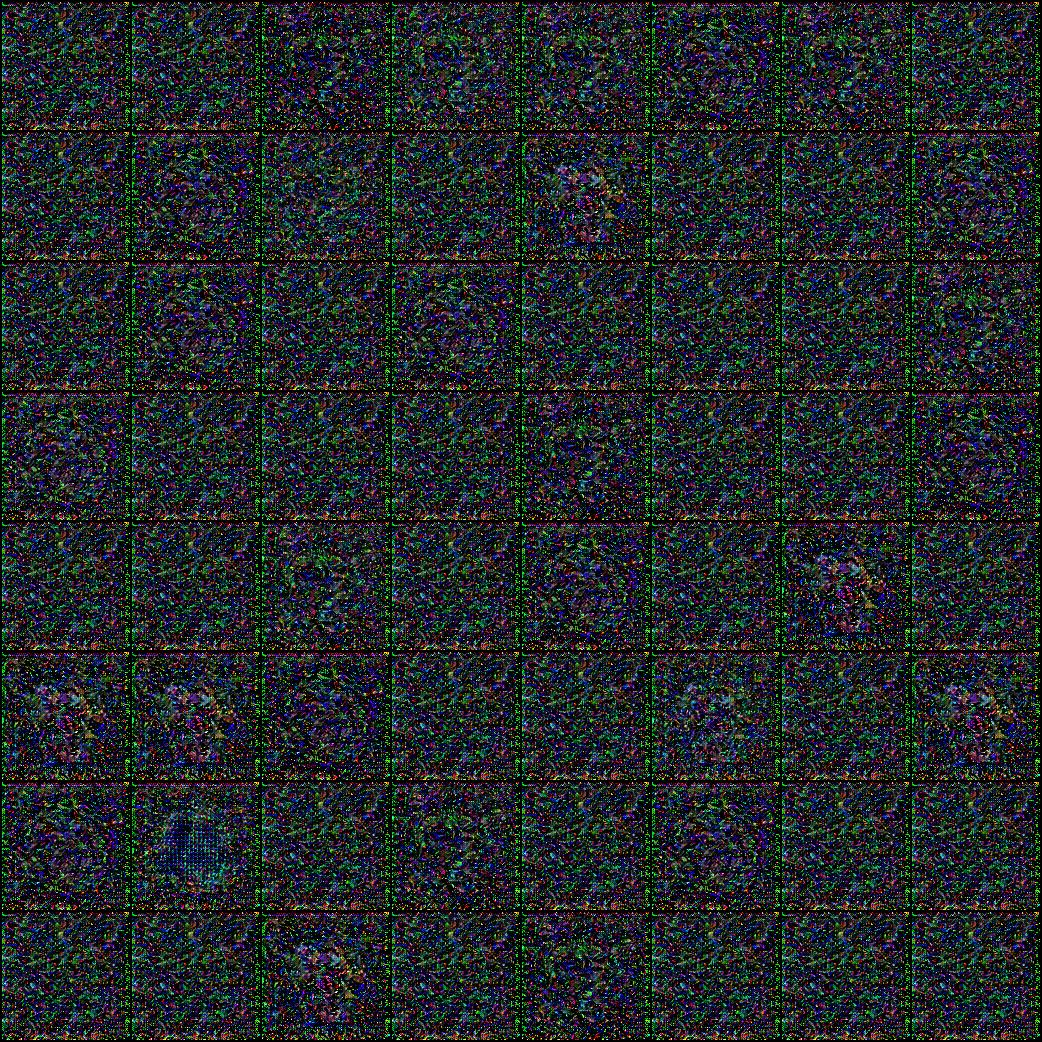

In [21]:
Image(filename='epochs_image/v15/pokemon-2000v1-5.jpg') 

Pikachu starts to become nightmares.

After 3000 epochs, the model doesn't seem to create better pokemon.

# Conclusions